# Autoencoders / Автоэнкодеры

---

Саликиев Денис 340290

---

При наличи вопросов по заданиям и для консультаций, можно писать в телеграмме [@vedyakov](https://t.me/vedyakov).

**Общие требования**
1. Самостоятельность выполнения.
2. Обоснованность выводов.
3. Код должен быть запускаем, результаты воспроизводимы. Если данные берутся с вашего гугл-диска, то должна быть доступна ссылка на эти данные.
4. Colab Notebook должен содержать результаты выполнения кода в ячейках.
5. Общая структура данного Colab Notebook сохранена. Вы можете вводить дополнительные разделы, писать дополнительные функции, не кардинально менять разделы. Если убираете какой-то текст и прочее, проследите, что все результаты выполнения задач остаются явно отмечены.
6. Для сдачи задания ссылка на Colab Notebook должна быть отправлена через [Google Form](https://forms.gle/AFpnYMKw4kKb1rUF7). Если хотите продолжить работу, сделайте копию. Успели ли вы до дедлайна, будет проверяться по дате изменения ноутбука (изменять ноутбук после отправки нельзя).

**Дедлайны:**
- Мягкий – 31.03.2025 23:59:59
- Жесткий – 03.04.2025 23:59:59







# Подготовка окружения

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка датасетов

In [ ]:
from torchvision.transforms import v2

custom_transforms = v2.Compose([
    transforms.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # v2.ToDtype(torch.float32, scale=True)
    # TODO: normalize and convert to tensor
])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=custom_transforms)
data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=custom_transforms)
data_loader_test = torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 39.6MB/s]


Проверим, что данные нормализованы

In [ ]:
print(np.mean(next(iter(data_loader_test))[0].numpy()))
print(np.std(next(iter(data_loader_test))[0].numpy()))

0.06008023
1.1151218


# Создание и обучение модели

In [ ]:
art = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(art.size())
art = art.view(art.size(0), -1)
print(art.size())
# art.view(3, 2)

torch.Size([3, 3])
torch.Size([3, 3])


In [ ]:
import torch


x = torch.randn(4, 4, 4)
print(x)
# print(x.view(-1))
print(x.size())
print(x.view(-1))
print(x.size())
# print(x.view(-1))

tensor([[[-0.1496, -0.4571, -0.1269,  0.8119],
         [-1.5571,  1.3382,  0.1799, -0.1347],
         [-0.0737, -0.5218,  1.6121,  1.5879],
         [ 1.4804,  2.2903, -0.2625,  0.2958]],

        [[-0.0455, -0.6012,  0.9824,  1.8920],
         [ 0.8926,  1.5002,  0.5339, -0.2729],
         [ 1.3257, -0.7402, -0.7858,  2.5397],
         [-0.0297,  0.3856,  0.1607,  1.8940]],

        [[-0.6125, -2.7215,  1.7647, -1.7106],
         [-0.9454, -0.6432,  1.4327,  2.2394],
         [ 0.5433, -1.8392,  1.0838,  0.4779],
         [ 0.3229, -0.0280,  0.6222,  0.2068]],

        [[-0.2387, -0.7845,  1.4943,  0.3506],
         [-1.3480,  1.2720,  0.7534,  0.2707],
         [ 0.9005,  0.9086, -1.0549, -1.1043],
         [ 1.8974,  0.6520,  0.1786,  0.8695]]])
torch.Size([4, 4, 4])
tensor([-0.1496, -0.4571, -0.1269,  0.8119, -1.5571,  1.3382,  0.1799, -0.1347,
        -0.0737, -0.5218,  1.6121,  1.5879,  1.4804,  2.2903, -0.2625,  0.2958,
        -0.0455, -0.6012,  0.9824,  1.8920,  0.8926,  1.50

In [ ]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(SimpleAutoencoder, self).__init__()
        # self.H = H
        # self.W = W

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride = 2),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(128 * 4 * 4, latent_dim)# TODO nn.Linear(..., ...)
        self.fc2 = nn.Linear(latent_dim, 128 * 4 * 4)# TODO nn.Linear(..., ...)

        self.decoder = nn.Sequential(
             nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.Sigmoid()
        )

    def forward(self, x):


        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        latent = self.fc1(x)
        x = self.fc2(latent)
        x = x.view(x.size(0), 128, 4, 4)
        x = self.decoder(x)

        return x, latent


In [ ]:
class SimpleAutoencoder2(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256 * 2 * 2)

        self.decoder = nn.Sequential(
             nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.BatchNorm2d(128),
             nn.ReLU(),
             nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(),
             nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.BatchNorm2d(32),
             nn.ReLU(),
             nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1, stride = 2, output_padding=1),
             nn.Sigmoid()
        )

    def forward(self, x):

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        latent = self.fc1(x)
        x = self.fc2(latent)
        x = x.view(x.size(0), 256, 2, 2)
        x = self.decoder(x)

        return x, latent


Функция обучения

In [ ]:
# prompt: generate train function for pytorch model with saving loss on train and calculcalting on test data each epoch, and plot losses and image example (we train autoencoder) with comparison with original image. Optimizer, data loaders, scheduler (can be None), number of epochs will be passed as function arguments. The function must return losses.

def train(model, optimizer, train_loader, test_loader, scheduler, num_epochs):
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, _ = data
            inputs = inputs.to(device)

            optimizer.zero_grad()

            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_loss_test = 0.0
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                inputs, _ = data
                inputs = inputs.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                running_loss_test += loss.item()

                # scheduler
                if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                    scheduler.step(loss)

            test_loss = running_loss_test / len(test_loader)
            test_losses.append(test_loss)

        if scheduler is not None and type(scheduler) is not type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Plot example images
        if (epoch + 2) % 10 == 0:
          with torch.no_grad():
              dataiter = iter(test_loader)
              images, _ = next(dataiter)
              images = images.to(device)
              outputs, _ = model(images)

              plt.figure(figsize=(10, 5))
              for i in range(5):
                  plt.subplot(2, 5, i + 1)
                  plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
                  plt.title('Original')
                  plt.axis('off')
                  plt.subplot(2, 5, i + 6)
                  plt.imshow(np.transpose(outputs[i].cpu().numpy(), (1, 2, 0)))
                  plt.title('Reconstructed')
                  plt.axis('off')
              plt.show()

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, test_losses

Создаем модель

Запуск обучения

In [ ]:
model = SimpleAutoencoder().to(device)# TODO

Epoch 1/50, Train Loss: 0.8206, Test Loss: 0.7094
Epoch 2/50, Train Loss: 0.7013, Test Loss: 0.6818
Epoch 3/50, Train Loss: 0.6836, Test Loss: 0.6685
Epoch 4/50, Train Loss: 0.6735, Test Loss: 0.6612
Epoch 5/50, Train Loss: 0.6669, Test Loss: 0.6574
Epoch 6/50, Train Loss: 0.6629, Test Loss: 0.6524
Epoch 7/50, Train Loss: 0.6602, Test Loss: 0.6489
Epoch 8/50, Train Loss: 0.6584, Test Loss: 0.6498
Epoch 9/50, Train Loss: 0.6571, Test Loss: 0.6476


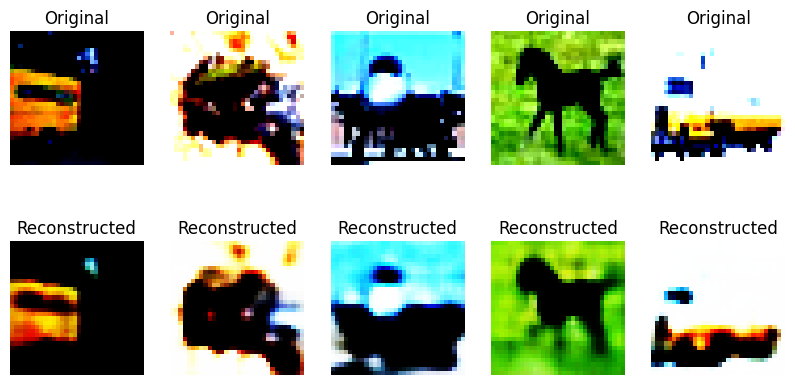

Epoch 10/50, Train Loss: 0.6560, Test Loss: 0.6485
Epoch 11/50, Train Loss: 0.6555, Test Loss: 0.6451
Epoch 12/50, Train Loss: 0.6549, Test Loss: 0.6446
Epoch 13/50, Train Loss: 0.6547, Test Loss: 0.6449
Epoch 14/50, Train Loss: 0.6542, Test Loss: 0.6477
Epoch 15/50, Train Loss: 0.6540, Test Loss: 0.6459
Epoch 16/50, Train Loss: 0.6538, Test Loss: 0.6461
Epoch 17/50, Train Loss: 0.6535, Test Loss: 0.6442
Epoch 18/50, Train Loss: 0.6534, Test Loss: 0.6454
Epoch 19/50, Train Loss: 0.6531, Test Loss: 0.6437


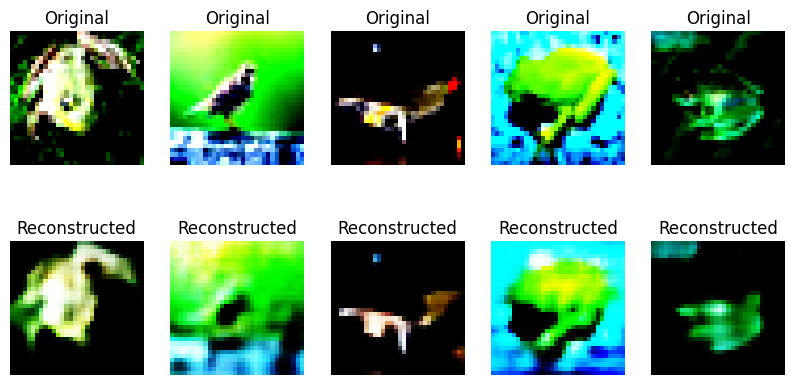

Epoch 20/50, Train Loss: 0.6531, Test Loss: 0.6419
Epoch 21/50, Train Loss: 0.6528, Test Loss: 0.6452
Epoch 22/50, Train Loss: 0.6528, Test Loss: 0.6456
Epoch 23/50, Train Loss: 0.6527, Test Loss: 0.6438
Epoch 24/50, Train Loss: 0.6526, Test Loss: 0.6449
Epoch 25/50, Train Loss: 0.6524, Test Loss: 0.6453
Epoch 26/50, Train Loss: 0.6523, Test Loss: 0.6434
Epoch 27/50, Train Loss: 0.6522, Test Loss: 0.6430
Epoch 28/50, Train Loss: 0.6522, Test Loss: 0.6442
Epoch 29/50, Train Loss: 0.6522, Test Loss: 0.6450


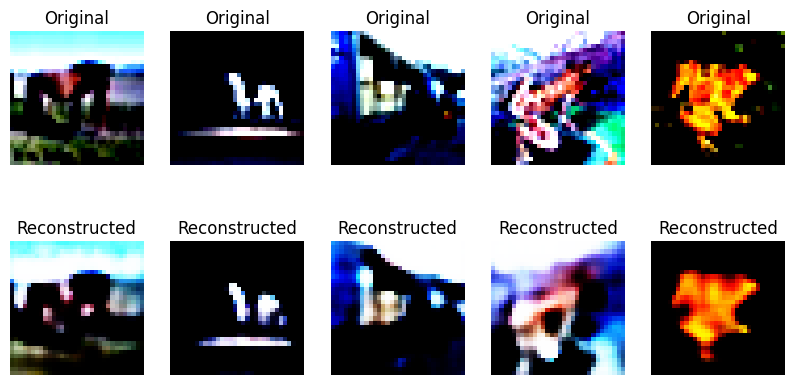

Epoch 30/50, Train Loss: 0.6520, Test Loss: 0.6447
Epoch 31/50, Train Loss: 0.6519, Test Loss: 0.6448
Epoch 32/50, Train Loss: 0.6518, Test Loss: 0.6446
Epoch 33/50, Train Loss: 0.6517, Test Loss: 0.6423
Epoch 34/50, Train Loss: 0.6517, Test Loss: 0.6418
Epoch 35/50, Train Loss: 0.6516, Test Loss: 0.6476
Epoch 36/50, Train Loss: 0.6516, Test Loss: 0.6455
Epoch 37/50, Train Loss: 0.6515, Test Loss: 0.6436
Epoch 38/50, Train Loss: 0.6515, Test Loss: 0.6431
Epoch 39/50, Train Loss: 0.6514, Test Loss: 0.6432


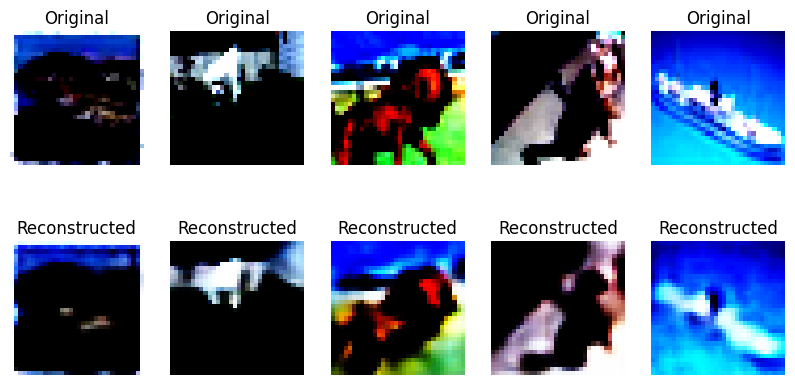

Epoch 40/50, Train Loss: 0.6513, Test Loss: 0.6427
Epoch 41/50, Train Loss: 0.6514, Test Loss: 0.6428
Epoch 42/50, Train Loss: 0.6511, Test Loss: 0.6439
Epoch 43/50, Train Loss: 0.6511, Test Loss: 0.6440
Epoch 44/50, Train Loss: 0.6512, Test Loss: 0.6437
Epoch 45/50, Train Loss: 0.6511, Test Loss: 0.6428
Epoch 46/50, Train Loss: 0.6510, Test Loss: 0.6421
Epoch 47/50, Train Loss: 0.6510, Test Loss: 0.6436
Epoch 48/50, Train Loss: 0.6510, Test Loss: 0.6447
Epoch 49/50, Train Loss: 0.6509, Test Loss: 0.6450


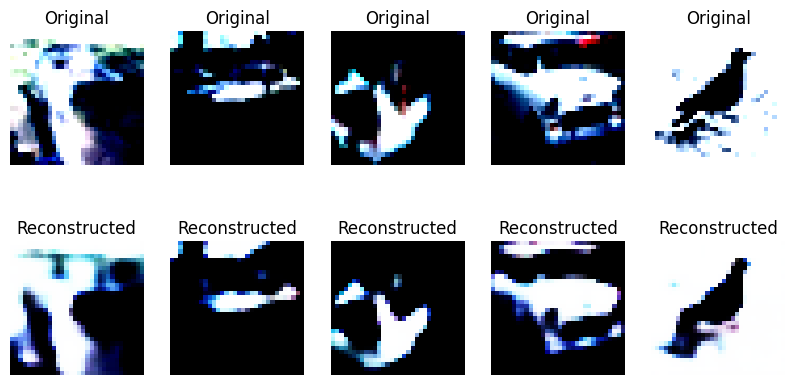

Epoch 50/50, Train Loss: 0.6508, Test Loss: 0.6449


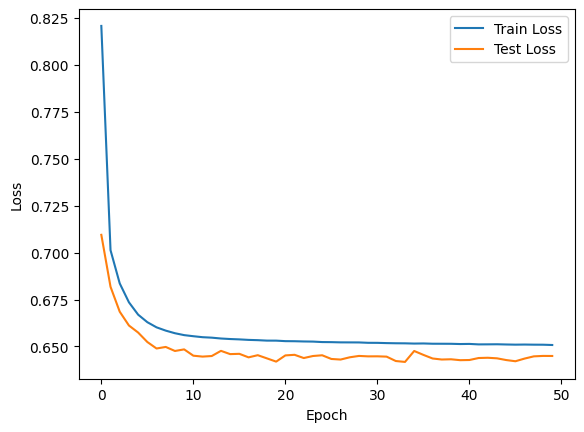

In [ ]:
model = SimpleAutoencoder().to(device)# TODO
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)# TODO
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = None

num_epochs = 50

train_losses3, test_losses3 = train(model, optimizer, data_loader, data_loader_test, scheduler, num_epochs)

Epoch 1/40, Train Loss: 0.7968, Test Loss: 0.6962
Epoch 2/40, Train Loss: 0.6966, Test Loss: 0.6768
Epoch 3/40, Train Loss: 0.6839, Test Loss: 0.6684
Epoch 4/40, Train Loss: 0.6769, Test Loss: 0.6646
Epoch 5/40, Train Loss: 0.6718, Test Loss: 0.6591
Epoch 6/40, Train Loss: 0.6682, Test Loss: 0.6578
Epoch 7/40, Train Loss: 0.6661, Test Loss: 0.6572
Epoch 8/40, Train Loss: 0.6642, Test Loss: 0.6538
Epoch 9/40, Train Loss: 0.6625, Test Loss: 0.6514


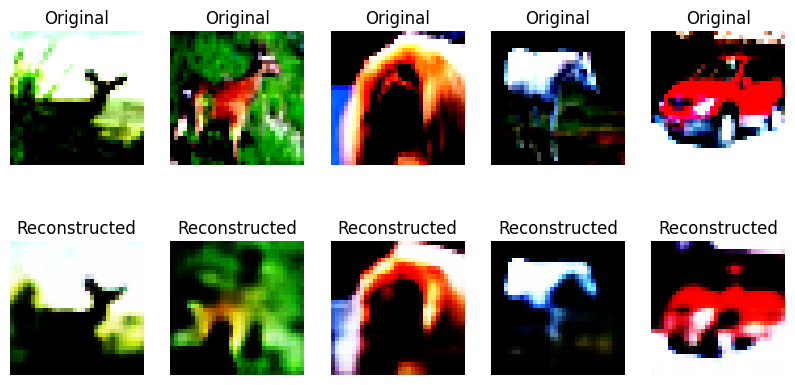

Epoch 10/40, Train Loss: 0.6613, Test Loss: 0.6500
Epoch 11/40, Train Loss: 0.6602, Test Loss: 0.6519
Epoch 12/40, Train Loss: 0.6592, Test Loss: 0.6516
Epoch 13/40, Train Loss: 0.6585, Test Loss: 0.6462
Epoch 14/40, Train Loss: 0.6577, Test Loss: 0.6494
Epoch 15/40, Train Loss: 0.6568, Test Loss: 0.6474
Epoch 16/40, Train Loss: 0.6562, Test Loss: 0.6459
Epoch 17/40, Train Loss: 0.6553, Test Loss: 0.6467
Epoch 18/40, Train Loss: 0.6543, Test Loss: 0.6459
Epoch 19/40, Train Loss: 0.6538, Test Loss: 0.6438


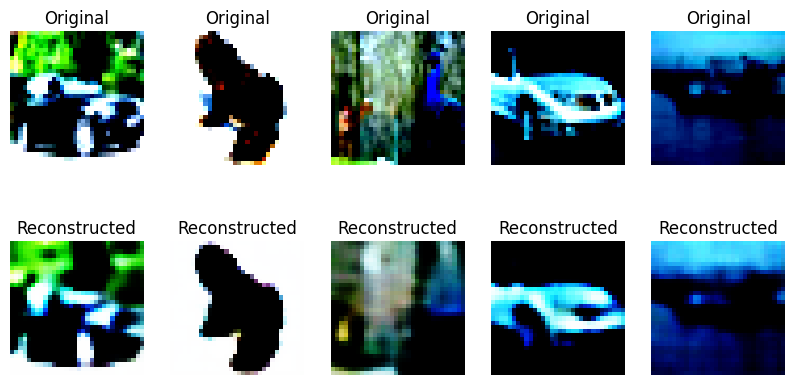

Epoch 20/40, Train Loss: 0.6534, Test Loss: 0.6429
Epoch 21/40, Train Loss: 0.6525, Test Loss: 0.6419
Epoch 22/40, Train Loss: 0.6519, Test Loss: 0.6415
Epoch 23/40, Train Loss: 0.6517, Test Loss: 0.6403
Epoch 24/40, Train Loss: 0.6515, Test Loss: 0.6405
Epoch 25/40, Train Loss: 0.6508, Test Loss: 0.6412
Epoch 26/40, Train Loss: 0.6505, Test Loss: 0.6396
Epoch 27/40, Train Loss: 0.6505, Test Loss: 0.6410
Epoch 28/40, Train Loss: 0.6500, Test Loss: 0.6413
Epoch 29/40, Train Loss: 0.6495, Test Loss: 0.6386


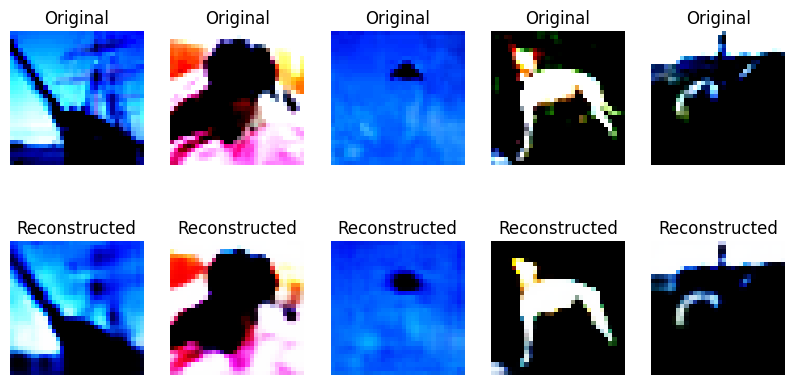

Epoch 30/40, Train Loss: 0.6494, Test Loss: 0.6401
Epoch 31/40, Train Loss: 0.6490, Test Loss: 0.6391
Epoch 32/40, Train Loss: 0.6486, Test Loss: 0.6390
Epoch 33/40, Train Loss: 0.6485, Test Loss: 0.6398
Epoch 34/40, Train Loss: 0.6481, Test Loss: 0.6375
Epoch 35/40, Train Loss: 0.6478, Test Loss: 0.6402
Epoch 36/40, Train Loss: 0.6476, Test Loss: 0.6371
Epoch 37/40, Train Loss: 0.6475, Test Loss: 0.6385
Epoch 38/40, Train Loss: 0.6474, Test Loss: 0.6377
Epoch 39/40, Train Loss: 0.6470, Test Loss: 0.6366


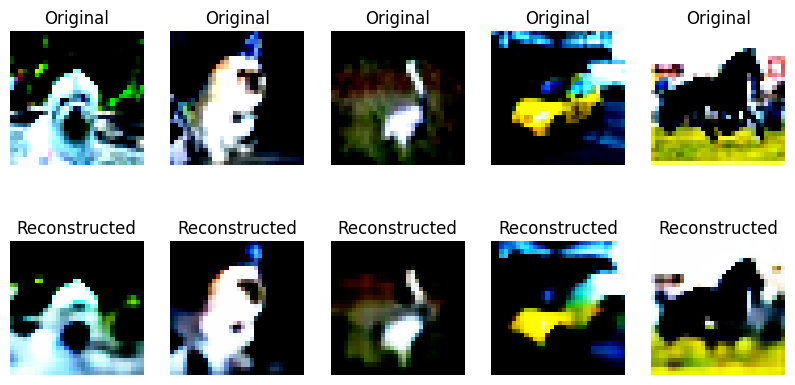

Epoch 40/40, Train Loss: 0.6468, Test Loss: 0.6354


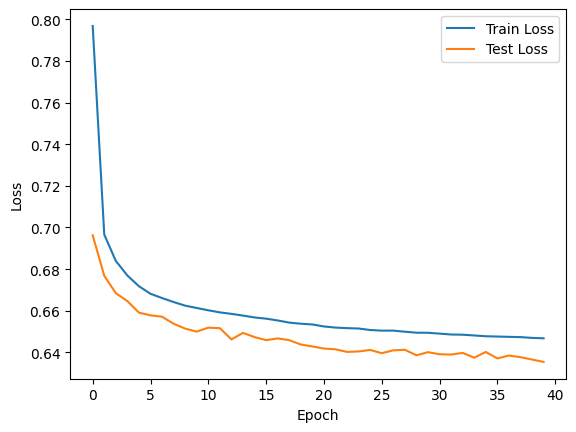

In [ ]:
model2 = SimpleAutoencoder2(latent_dim = 256).to(device)# TODO
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)# TODO
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = None

num_epochs = 40

train_losses3, test_losses3 = train(model2, optimizer, data_loader, data_loader_test, scheduler, num_epochs)

Epoch 1/40, Train Loss: 0.6467, Test Loss: 0.6376
Epoch 2/40, Train Loss: 0.6466, Test Loss: 0.6389
Epoch 3/40, Train Loss: 0.6461, Test Loss: 0.6351
Epoch 4/40, Train Loss: 0.6458, Test Loss: 0.6361
Epoch 5/40, Train Loss: 0.6460, Test Loss: 0.6359
Epoch 6/40, Train Loss: 0.6456, Test Loss: 0.6363
Epoch 7/40, Train Loss: 0.6456, Test Loss: 0.6375
Epoch 8/40, Train Loss: 0.6453, Test Loss: 0.6372
Epoch 9/40, Train Loss: 0.6451, Test Loss: 0.6369


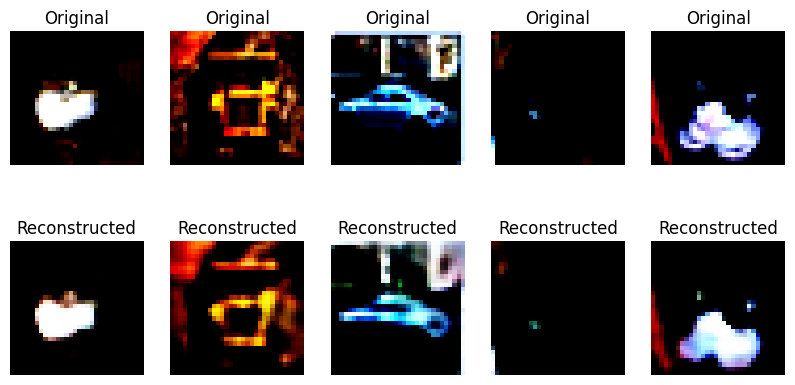

Epoch 10/40, Train Loss: 0.6449, Test Loss: 0.6363
Epoch 11/40, Train Loss: 0.6446, Test Loss: 0.6358
Epoch 12/40, Train Loss: 0.6445, Test Loss: 0.6326
Epoch 13/40, Train Loss: 0.6443, Test Loss: 0.6368
Epoch 14/40, Train Loss: 0.6443, Test Loss: 0.6343
Epoch 15/40, Train Loss: 0.6440, Test Loss: 0.6377
Epoch 16/40, Train Loss: 0.6440, Test Loss: 0.6335
Epoch 17/40, Train Loss: 0.6438, Test Loss: 0.6354
Epoch 18/40, Train Loss: 0.6436, Test Loss: 0.6342
Epoch 19/40, Train Loss: 0.6435, Test Loss: 0.6358


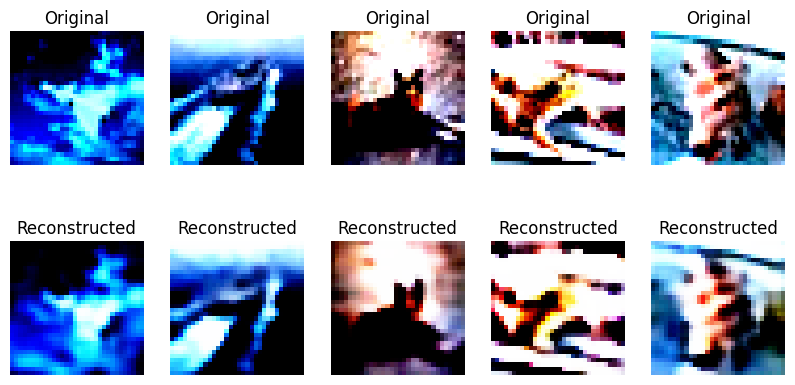

Epoch 20/40, Train Loss: 0.6433, Test Loss: 0.6365
Epoch 21/40, Train Loss: 0.6432, Test Loss: 0.6339
Epoch 22/40, Train Loss: 0.6432, Test Loss: 0.6334
Epoch 23/40, Train Loss: 0.6431, Test Loss: 0.6333
Epoch 24/40, Train Loss: 0.6429, Test Loss: 0.6331
Epoch 25/40, Train Loss: 0.6428, Test Loss: 0.6346
Epoch 26/40, Train Loss: 0.6428, Test Loss: 0.6357
Epoch 27/40, Train Loss: 0.6427, Test Loss: 0.6322
Epoch 28/40, Train Loss: 0.6424, Test Loss: 0.6328
Epoch 29/40, Train Loss: 0.6424, Test Loss: 0.6330


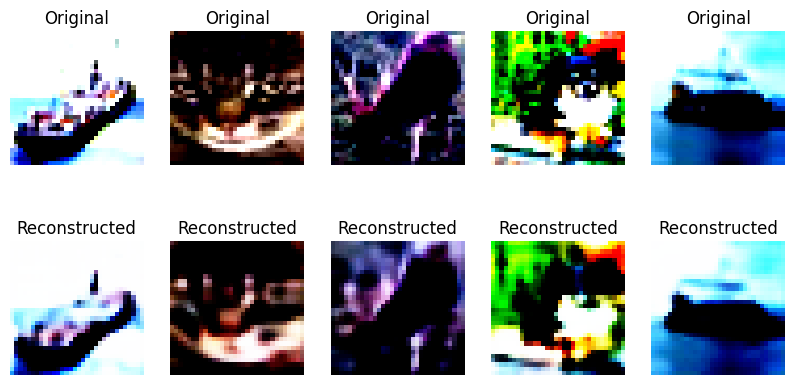

Epoch 30/40, Train Loss: 0.6423, Test Loss: 0.6332
Epoch 31/40, Train Loss: 0.6422, Test Loss: 0.6314
Epoch 32/40, Train Loss: 0.6420, Test Loss: 0.6327
Epoch 33/40, Train Loss: 0.6420, Test Loss: 0.6321
Epoch 34/40, Train Loss: 0.6418, Test Loss: 0.6320
Epoch 35/40, Train Loss: 0.6418, Test Loss: 0.6345
Epoch 36/40, Train Loss: 0.6416, Test Loss: 0.6326
Epoch 37/40, Train Loss: 0.6415, Test Loss: 0.6324
Epoch 38/40, Train Loss: 0.6413, Test Loss: 0.6314
Epoch 39/40, Train Loss: 0.6413, Test Loss: 0.6320


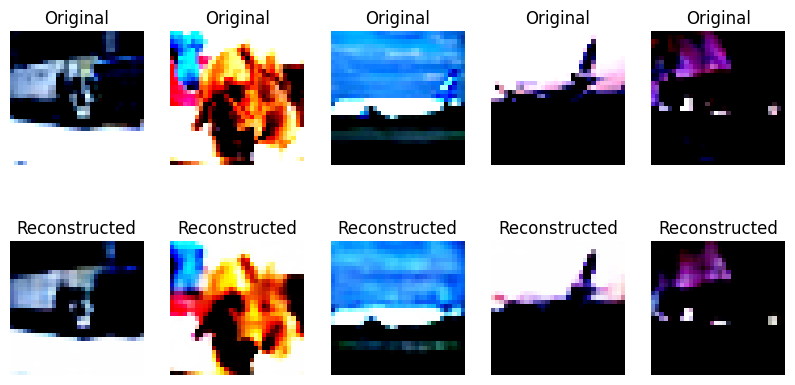

Epoch 40/40, Train Loss: 0.6413, Test Loss: 0.6321


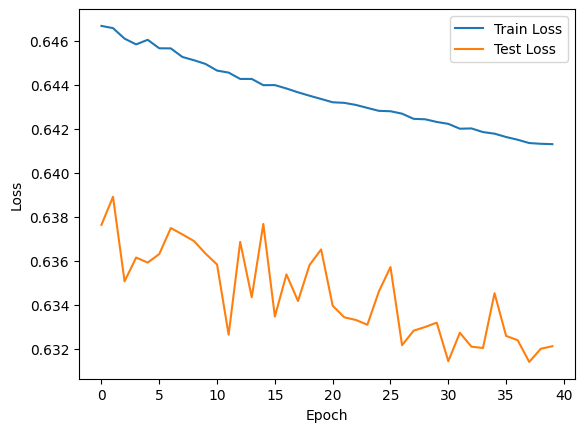

In [ ]:
num_epochs = 40

train_losses4, test_losses4 = train(model2, optimizer, data_loader, data_loader_test, scheduler, num_epochs)

Загрузка обученной модели

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Ссылка на веса модели:
https://drive.google.com/file/d/1-4wModDONyMWwJ3Jj0uKDEeHYNj0nqxU/view?usp=sharing

In [ ]:
model = SimpleAutoencoder2(latent_dim = 256).to(device)# TODO

In [ ]:
path = '/content/gdrive/MyDrive/model_parameters/model_autoencoder2.pth'
torch.save(model.state_dict(), path)

# Провести кластеризацию изображений

1. Отобрать вручную изображения восьми классов
2. Вывести 12 отобранных изображений
3. Кластеризовать **при неизвестном количестве кластеров** с помощью и проверить сколько кластеров получается
4. Описать идеи, что общего в кластерах

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Отобрать вручную изображения восьми классов (например, первые 8 классов CIFAR10)
num_classes_to_select = 8
selected_images = []#TODO
selected_labels = []#TODO
count_labels = np.zeros(num_classes_to_select)

for images, labels in data_loader_test:
    for i in range(len(images)):
        if labels[i] < num_classes_to_select:
            if count_labels[labels[i]] == 100:
                break;
            count_labels[labels[i]] += 1
            selected_images.append(images[i])
            selected_labels.append(labels[i].cpu().numpy())

        if len(selected_images) == 100 * num_classes_to_select:
            break



In [ ]:
np.unique(selected_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([100,  86, 100, 100, 100,  97, 100, 100]))

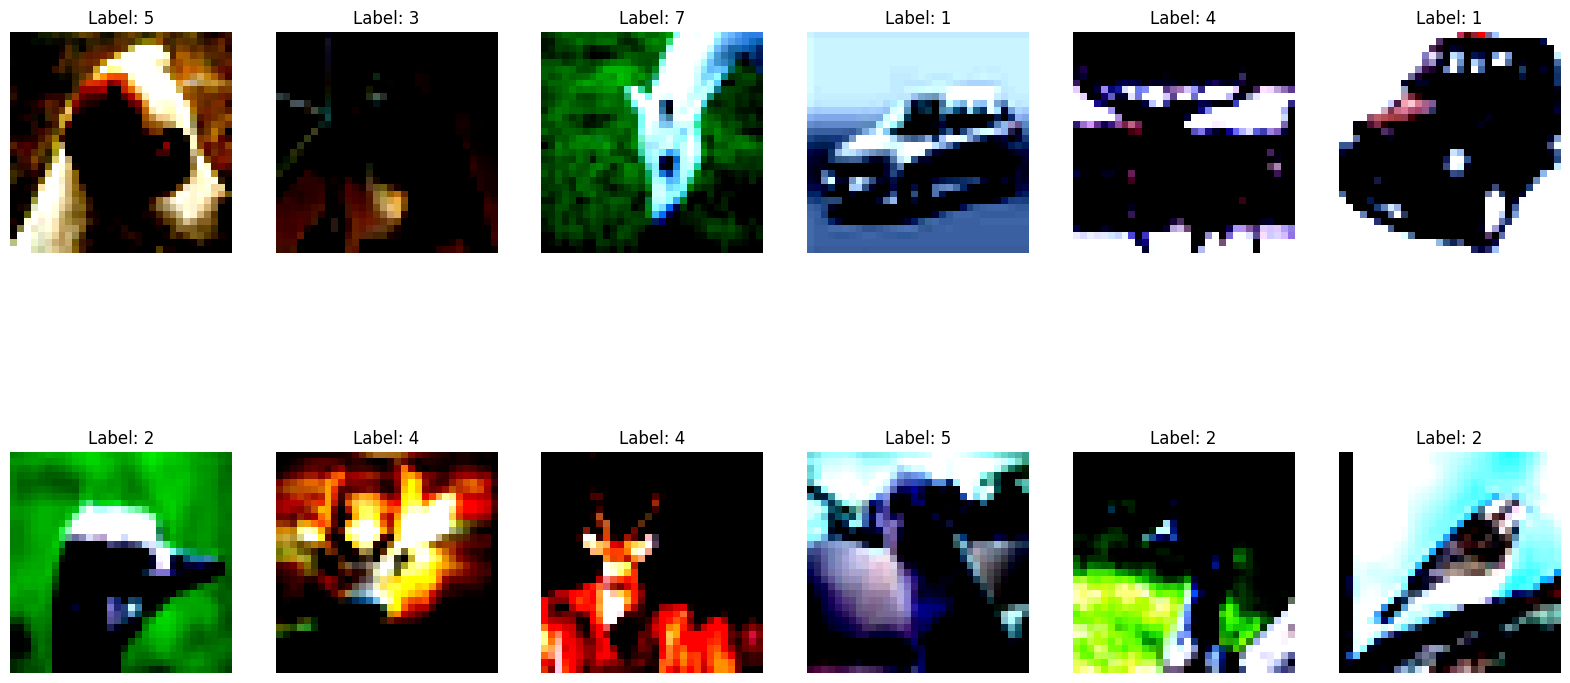

In [ ]:
# 2. Вывести изображения
plt.figure(figsize=(20, 10))
for i in range(len(selected_images[:12])):
    plt.subplot(2, 6, i + 1)
    plt.imshow(selected_images[i].permute(1, 2, 0))
    #TODO plt.imshow
    plt.title(f'Label: {selected_labels[i]}')
    plt.axis('off')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    latent_vectors = []
    for image in selected_images:
        image = image.unsqueeze(0)
        _, latent = model(image.to(device))
        latent_vectors.append(latent.cpu().numpy().flatten())

scaler = StandardScaler()
scaled_latent_vectors = scaler.fit_transform(latent_vectors)


In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db=DBSCAN(eps=13, min_samples=2).fit(scaled_latent_vectors)
labels=db.labels_

n_clusters=len(set(labels))-(1 if -1 in labels else 0)
n_noise_=list(labels).count(-1)

print("estimated number of clusters: %d" % n_clusters)
print("estimated number of noise points: %d" % n_noise_)

estimated number of clusters: 3
estimated number of noise points: 446


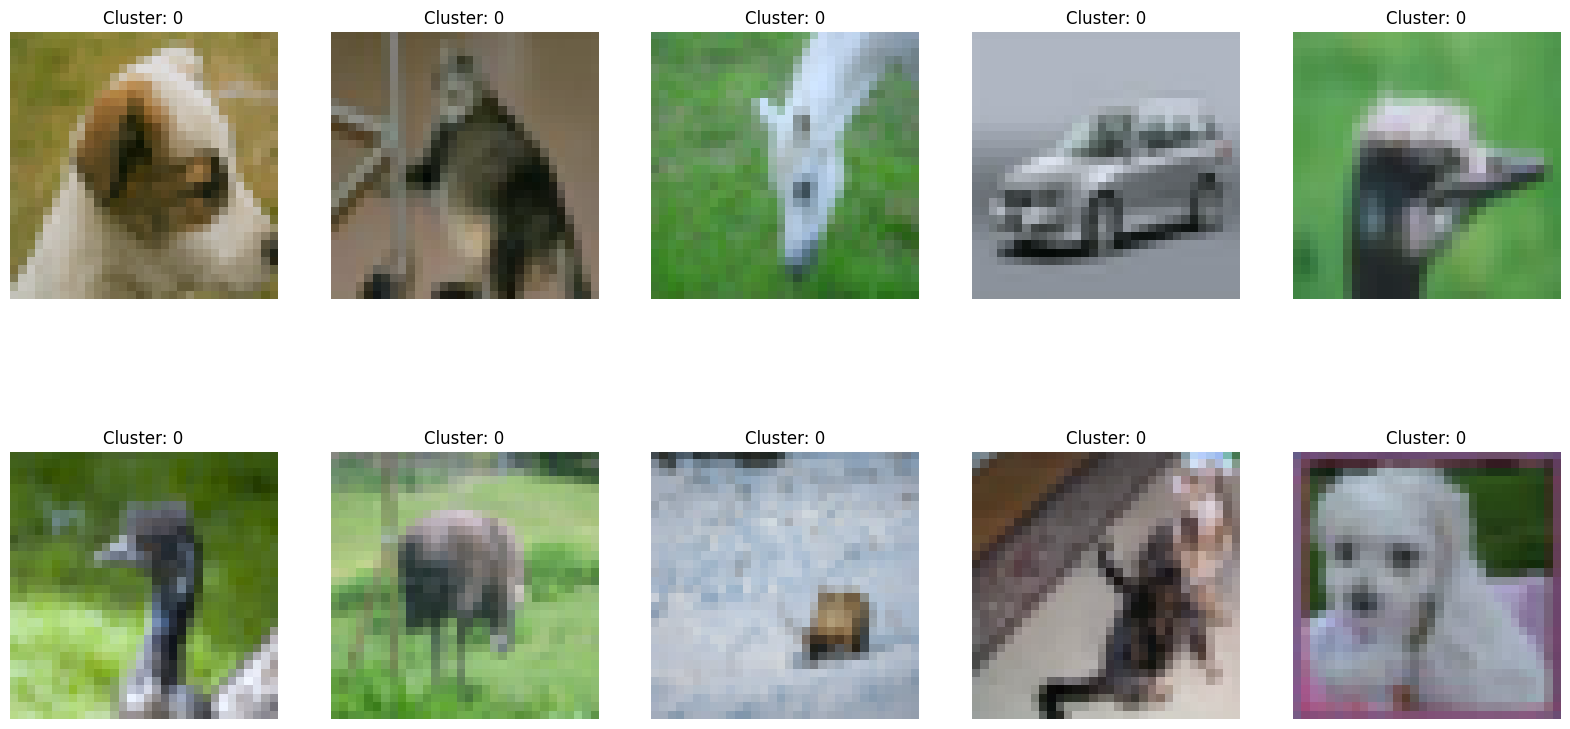

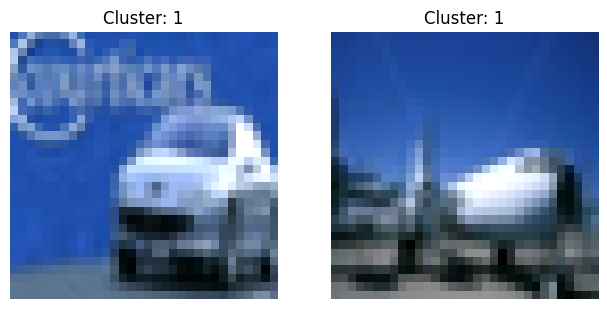

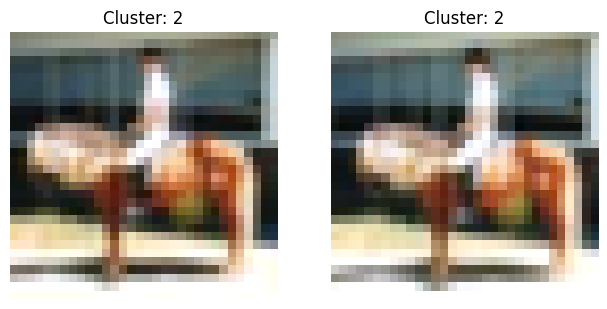

In [ ]:
# 4. Анализ кластеров - что общего в каждом кластере
cluster_images={}
for i,label in enumerate(labels):
    if label != -1:
        if label not in cluster_images:
            cluster_images[label]=[]
        if len(cluster_images[label])<10:
            cluster_images[label].append(selected_images[i])

for cluster_label, images in cluster_images.items():
    plt.figure(figsize=(20, 10))
    for i,image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        inp=image.numpy().transpose((1,2,0))
        mean=np.array((0.4914, 0.4822, 0.4465))
        std=np.array((0.247, 0.243, 0.261))
        inp=std*inp+mean
        inp=np.clip(inp, 0, 1)
        plt.imshow(inp)
        plt.title(f'Cluster: {cluster_label}')
        plt.axis('off')
    plt.show()

In [ ]:
db=DBSCAN(eps=11, min_samples=2).fit(scaled_latent_vectors)
labels=db.labels_

n_clusters=len(set(labels))-(1 if -1 in labels else 0)
n_noise_=list(labels).count(-1)

print("estimated number of clusters: %d" % n_clusters)
print("estimated number of noise points: %d" % n_noise_)

estimated number of clusters: 7
estimated number of noise points: 636


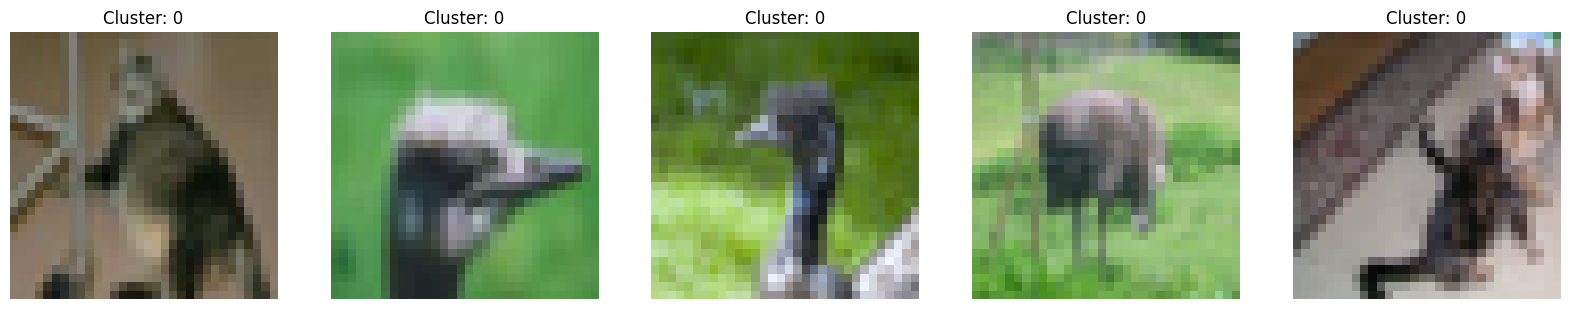

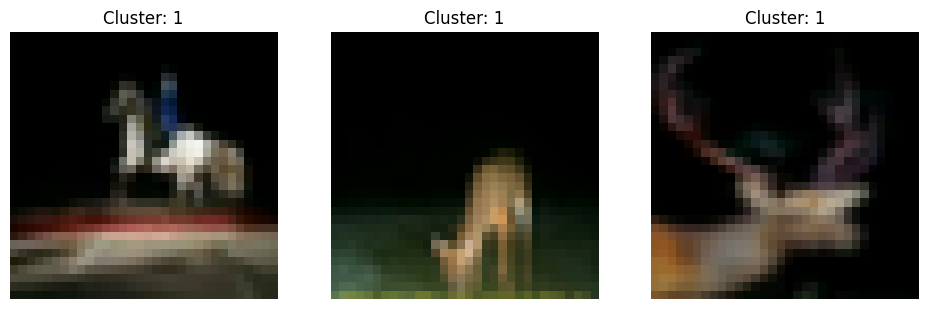

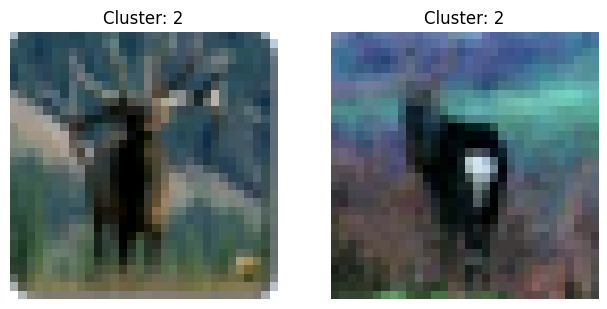

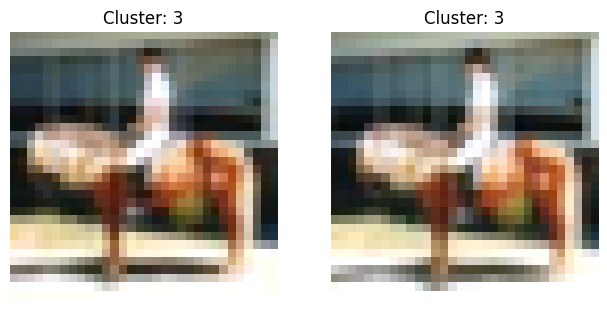

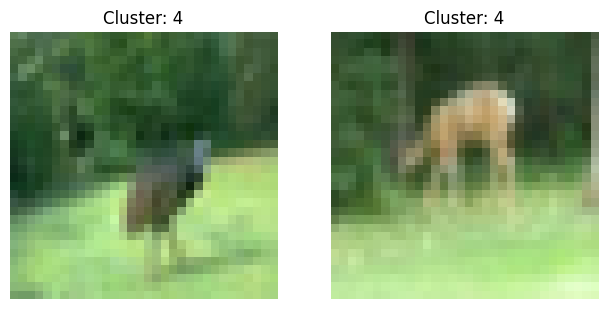

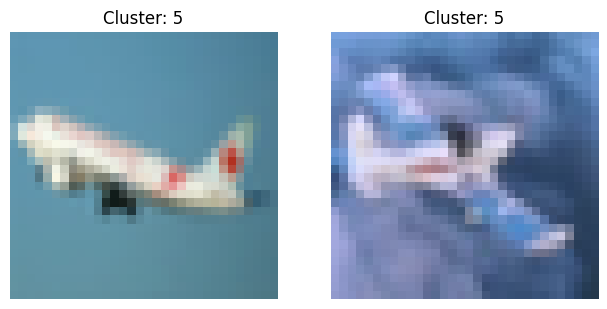

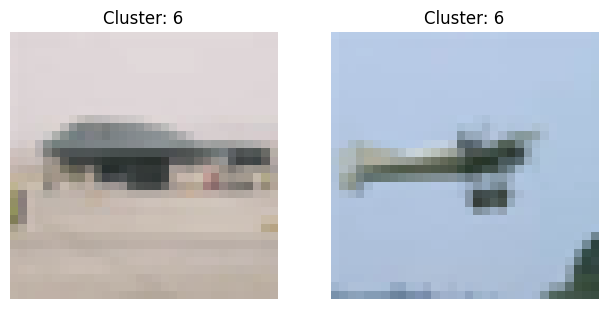

In [ ]:
cluster_images={}
for i,label in enumerate(labels):
    if label != -1:
        if label not in cluster_images:
            cluster_images[label]=[]
        if len(cluster_images[label])<5:
            cluster_images[label].append(selected_images[i])

for cluster_label, images in cluster_images.items():
    plt.figure(figsize=(20, 10))
    for i,image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        inp=image.numpy().transpose((1,2,0))
        mean=np.array((0.4914, 0.4822, 0.4465))
        std=np.array((0.247, 0.243, 0.261))
        inp=std*inp+mean
        inp=np.clip(inp, 0, 1)
        plt.imshow(inp)
        plt.title(f'Cluster: {cluster_label}')
        plt.axis('off')
    plt.show()

In [ ]:
db=DBSCAN(eps=13.6, min_samples=2).fit(scaled_latent_vectors)
labels=db.labels_

n_clusters=len(set(labels))-(1 if -1 in labels else 0)
n_noise_=list(labels).count(-1)

print("estimated number of clusters: %d" % n_clusters)
print("estimated number of noise points: %d" % n_noise_)

estimated number of clusters: 6
estimated number of noise points: 394


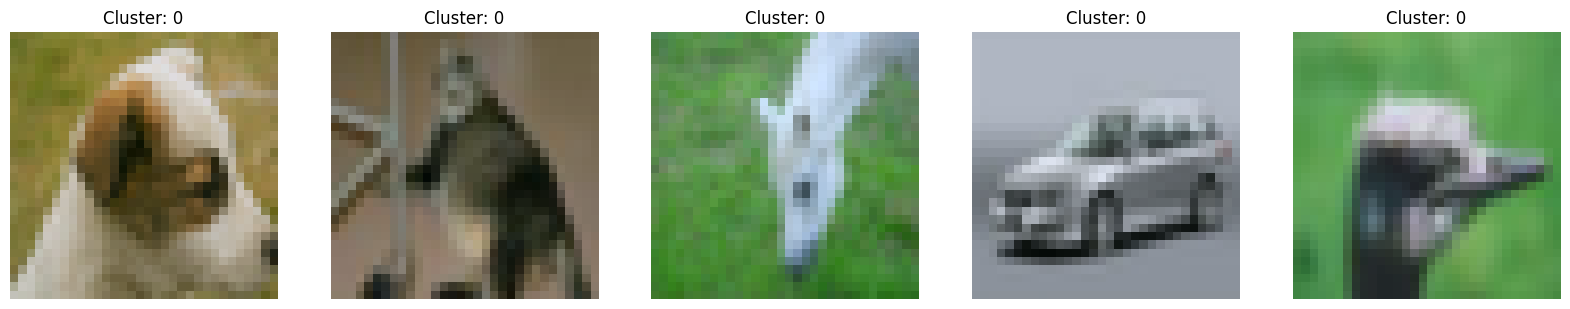

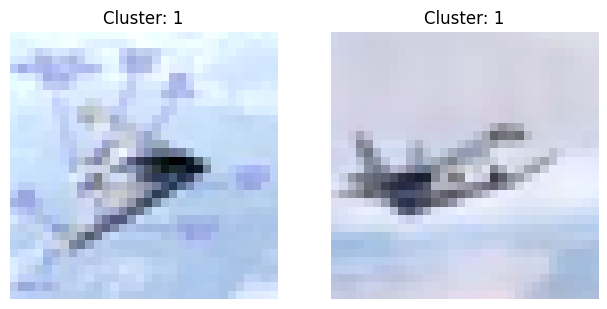

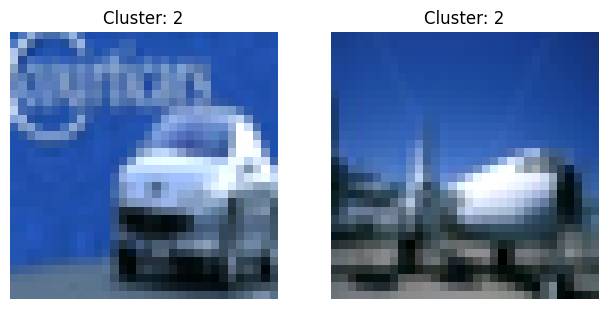

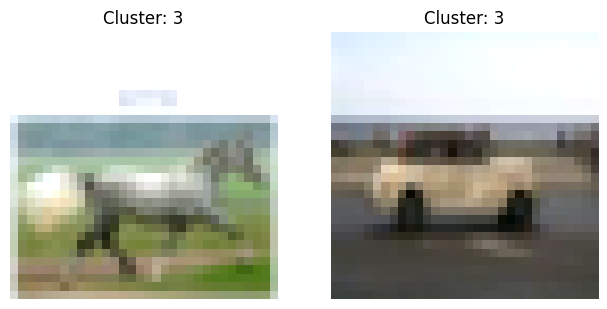

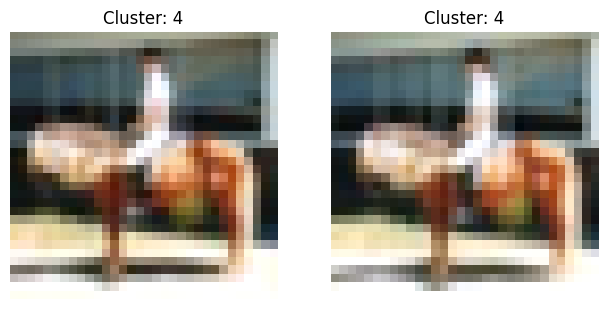

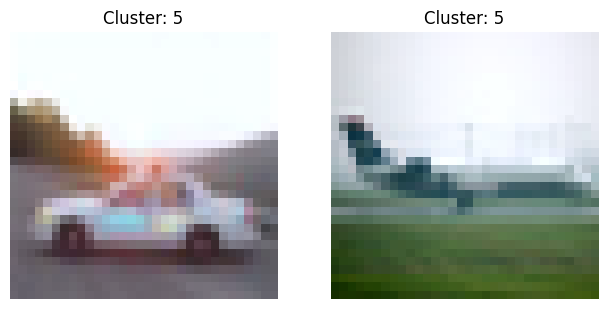

In [ ]:
cluster_images={}
for i,label in enumerate(labels):
    if label != -1:
        if label not in cluster_images:
            cluster_images[label]=[]
        if len(cluster_images[label])<5:
            cluster_images[label].append(selected_images[i])

for cluster_label, images in cluster_images.items():
    plt.figure(figsize=(20, 10))
    for i,image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        inp=image.numpy().transpose((1,2,0))
        mean=np.array((0.4914, 0.4822, 0.4465))
        std=np.array((0.247, 0.243, 0.261))
        inp=std*inp+mean
        inp=np.clip(inp, 0, 1)
        plt.imshow(inp)
        plt.title(f'Cluster: {cluster_label}')
        plt.axis('off')
    plt.show()

In [ ]:
db=DBSCAN(eps=14, min_samples=2).fit(scaled_latent_vectors)
labels=db.labels_

n_clusters=len(set(labels))-(1 if -1 in labels else 0)
n_noise_=list(labels).count(-1)

print("estimated number of clusters: %d" % n_clusters)
print("estimated number of noise points: %d" % n_noise_)

estimated number of clusters: 5
estimated number of noise points: 355


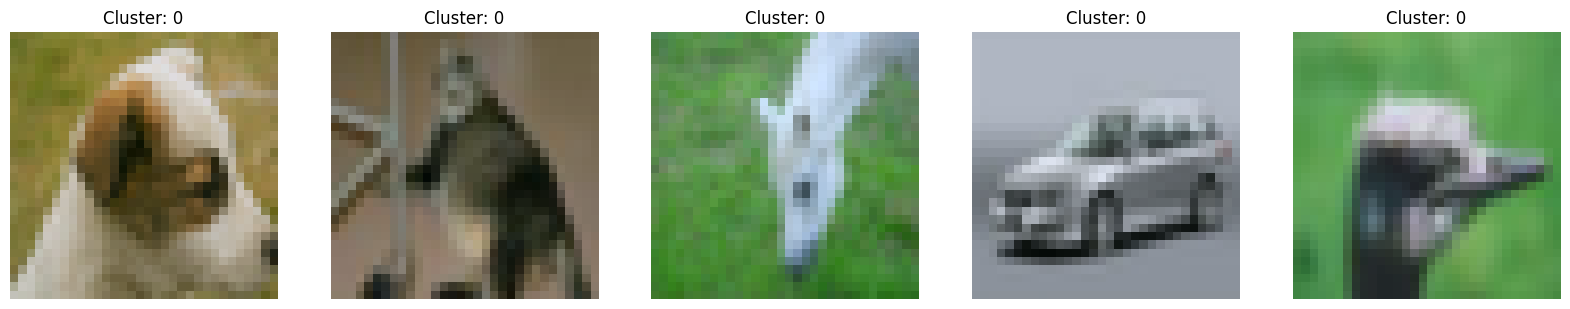

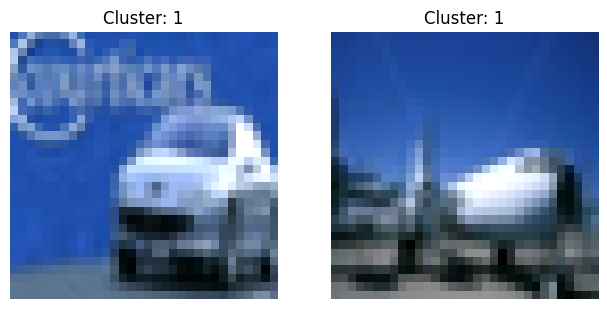

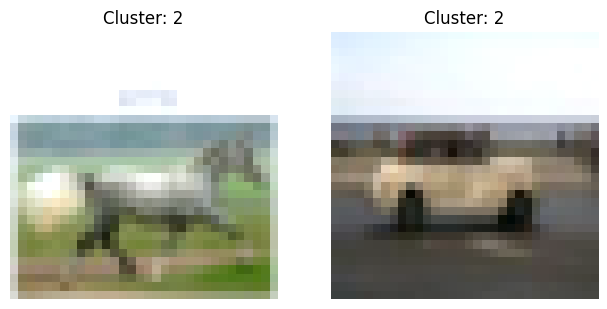

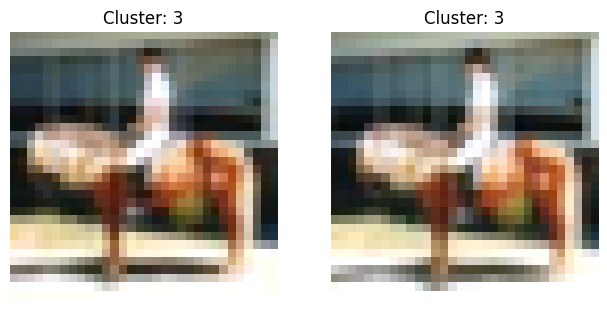

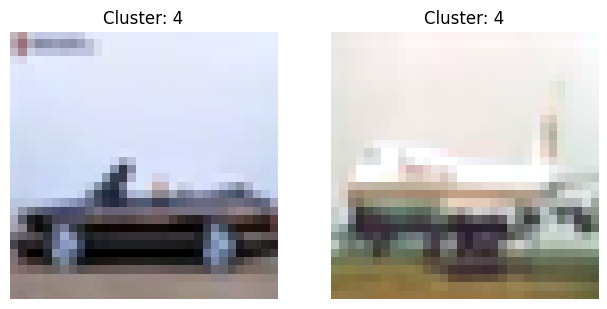

In [ ]:
cluster_images={}
for i,label in enumerate(labels):
    if label != -1:
        if label not in cluster_images:
            cluster_images[label]=[]
        if len(cluster_images[label])<5:
            cluster_images[label].append(selected_images[i])

for cluster_label, images in cluster_images.items():
    plt.figure(figsize=(20, 10))
    for i,image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        inp=image.numpy().transpose((1,2,0))
        mean=np.array((0.4914, 0.4822, 0.4465))
        std=np.array((0.247, 0.243, 0.261))
        inp=std*inp+mean
        inp=np.clip(inp, 0, 1)
        plt.imshow(inp)
        plt.title(f'Cluster: {cluster_label}')
        plt.axis('off')
    plt.show()

### Заключение:
В ходе лабораторной работы был создан свой автоэнкодер. Затем алгоритмом кластеризации DBSCAN был произведен поиск кластеров в латентном пространстве тестовых изображений. Наибольшее получившиеся количество кластеров составило 7 при шумовых 636 изображений. Наименьшее количество шумовых изображений составило 355 при 5 кластерах. В кластерах наблюдаются схожести по цветовой гамме. Из-за схожести по цветам кластеризатор кластеризировал картинки одних и тех же объектов в не сильно разнящихся цветовых гаммах. В данных примерах он выделял лошадей, самолеты с машинами, оленей. Похожие цветовые гаммы также влияли на  смешивание разных объектов в одних кластерах. Также в некоторых кластерах есть схожести по геометрии объектов и фона. Можно предположить, что латентные признаки смогли выделить признаки цветов и геометрии картинок